### Introduction
In this notebook we will explore timeseries dataset of user computer authentication events. Data is collected from the Los Alamos National Laboratory (LANL) enterprise network. Dataset consist of 9 months with 708,304,516 authentication events.Each entry in dataset is for form 'timestamp','user id', 'computer id'. Dataset is completely anonymizated, timestamp is represented relative to first time entry in dataset which is considered to as 1, actual user id and computer name or ip address is replaced by series like U1, U2, U3 etc and C1, C2, C3 etc. More information on dataset is available at https://csr.lanl.gov/data/auth/ 

This notebook is written in free google collab environment and in notebook will use first one month of data. However in forecating user login pattern we have used next month of data as test date

#### Data loading and structure exploration

In [22]:
#Reading data from google drive. This step will vary based on runtime environment and location of raw data file
zip_path = '/content/drive/My Drive/ML_Data/Authentication_dataset.zip'
!cp "{zip_path}" .
!unzip -q Authentication_dataset.zip
!rm Authentication_dataset.zip

^C
[Authentication_dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Authentication_dataset.zip or
        Authentication_dataset.zip.zip, and cannot find Authentication_dataset.zip.ZIP, period.


In [23]:
#Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sn
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.testing import assert_frame_equal
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense,Activation,Dropout

In [24]:
# In this notebook we will explore first one month of dataset
df = pd.read_csv('lanl-auth-dataset-1-00',names = ['timestamp','user_id','comp_id'])

#### Data exploration

In [25]:
# Datatypes in dataframe
df.dtypes

timestamp     int64
user_id      object
comp_id      object
dtype: object

In [26]:
df.shape

(67054840, 3)

In [27]:
df.head(10)

,timestamp,user_id,comp_id
0,1,U1,C1
1,1,U1,C2
2,2,U2,C3
3,3,U3,C4
4,6,U4,C5
5,7,U4,C5
6,7,U5,C6
7,8,U6,C7
8,11,U7,C8
9,12,U8,C9


In [28]:
print('Unique users {:d} '.format(df.user_id.nunique()))
print('Unique computers {:d} '.format(df.comp_id.nunique()))
print('Dataset time duration {:.1f} days '.format((df['timestamp'].max()/(60*60*24))))

Unique users 9924 
Unique computers 14822 
Dataset time duration 28.0 days 


#### Authentication connection analysis
In this section of notebook we will look at the pattern generated by authentication events over period of time and rate at which authentication events are generated

Identifying pattern of authentication events every day of month

In [29]:
# Aggregating authentication request in a day
timestamp_day_boundary = 1*24*60*60
days = df['timestamp'].max()/timestamp_day_boundary
daliy_conn = []
for i in range(int(days)):
  df_daily = df[(df['timestamp'] > i*timestamp_day_boundary) & (df['timestamp'] < (i+1)*timestamp_day_boundary)]
  daliy_conn.append(df_daily.shape[0])

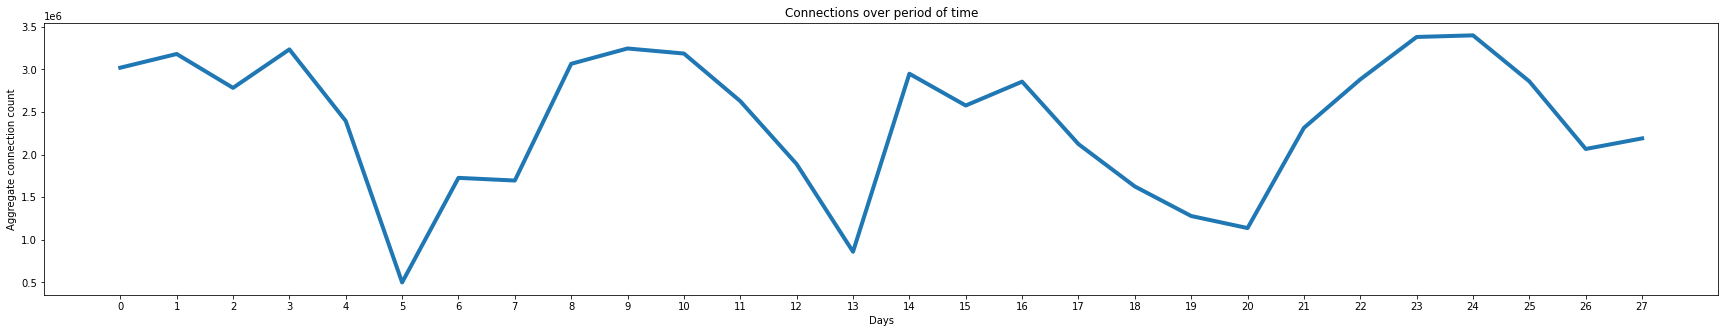

In [30]:
# Visualisation - authentication request per day for a period of month
plt.figure(figsize=(30,5))
plt.plot(np.arange(len(daliy_conn)),daliy_conn,linewidth=4)
plt.xticks(np.arange(len(daliy_conn)))
plt.title('Connections over period of time')
plt.xlabel('Days')
plt.ylabel('Aggregate connection count')
plt.show()

There is a prodicity in authentication events over days which can be attributed to working days and non-working days of a week or month

In [31]:
#Analysing data dispersion 
print('Maximum daily connections observed in time period {:d} '.format(max(daliy_conn)))
print('Minimum daily connections observed in time period {:d} '.format(min(daliy_conn)))
print('Median of daily connections observed in time period {:.2f} '.format(statistics.median(daliy_conn)))

Maximum daily connections observed in time period 3399774 
Minimum daily connections observed in time period 499677 
Median of daily connections observed in time period 2601913.00 


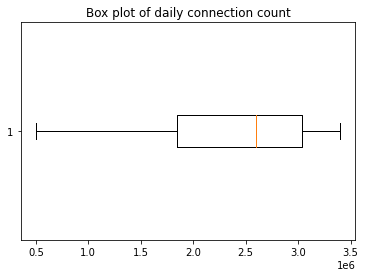

In [32]:
#Data dispersion visualisation using box plot
plt.boxplot(daliy_conn,vert=False)
plt.title('Box plot of daily connection count')
plt.show()

This is left-skewed graph indicating daily connection counts form a long tail for lower values

In [33]:
# Aggregating events per epochs
conn_per_sec = df['timestamp'].value_counts()
conn_per_sec_df = pd.DataFrame({'timestamp':conn_per_sec.index,'count':conn_per_sec.values}).sort_values('timestamp').reset_index(drop = True)

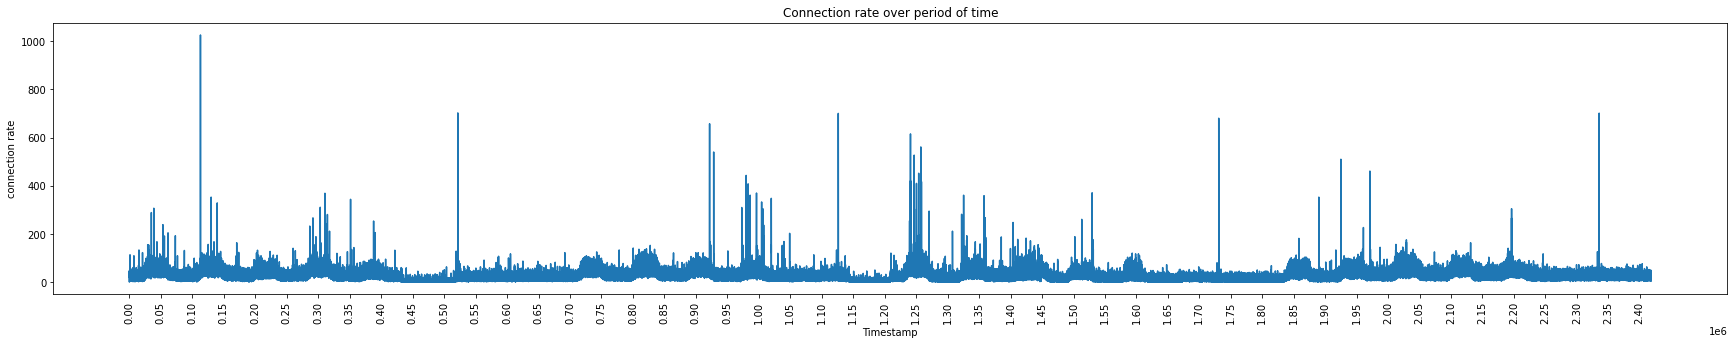

In [34]:
# Visualisation - aggregate authentication events per epoch 
plt.figure(figsize=(30,5))
plt.plot(conn_per_sec_df['timestamp'],conn_per_sec_df['count'])
plt.title('Connection rate over period of time')
plt.xlabel('Timestamp')
plt.xticks(conn_per_sec_df['timestamp'][::50000],  rotation='vertical')
plt.ylabel('connection rate')
plt.show()

There are bust of events observed in graph, which can be further looked in by the network administrator to understand authentication pattern

In [35]:
print('Maximum rate of {:d} connections per epoch '.format(conn_per_sec_df['count'].max()))
print('Minimum rate of {:d} connections per epoch '.format(conn_per_sec_df['count'].min()))
print('Median rate of {:.2f} connections per epoch'.format(conn_per_sec_df['count'].median()))

Maximum rate of 1025 connections per epoch 
Minimum rate of 1 connections per epoch 
Median rate of 24.00 connections per epoch


As maximum authentication request per epoch is 1025, authentication server should be able handle this rate of authentication

####User Dimmernsion Analysis
In this section we will explore patterns generated by user 


In [36]:
# Aggregating authentication request on per user basis
user_id_series = df['user_id'].value_counts()
user_id_df = pd.DataFrame({'user_id':user_id_series.index,'count':user_id_series.values})
user_id_df['user_id_temp'] = user_id_df['user_id'].str.split('U',expand = True)[1].astype('int32')
user_id_df = user_id_df.sort_values('user_id_temp', ascending=True).drop(['user_id_temp'], axis = 1).reset_index(drop=True)

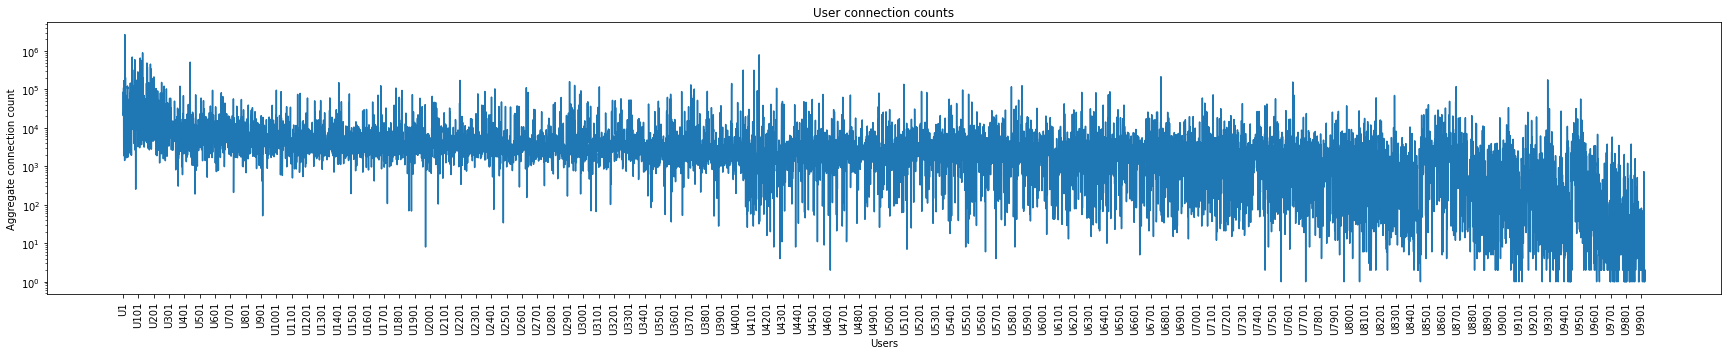

In [37]:
# Visualizing aggegate authentication request on per user basis
plt.figure(figsize=(30,5))
plt.yscale('log')
plt.plot(user_id_df['user_id'],user_id_df['count'])
plt.title('User connection counts')
plt.xlabel('Users')
plt.ylabel('Aggregate connection count')
plt.xticks(user_id_df['user_id'][::100],  rotation='vertical')
plt.show()

There is a variability between users in terms of aggregate count of authentication request generated over a period of time under observation. Also initial users like U1 are generating more authentication request as compared users having id's ending with higher number like U9901. This pattern can be further explored by understanding allocation of user id in organisation

In [38]:
#Data dispersion analysis
print('Maximum connections by user {:d} '.format(user_id_df['count'].max()))
print('Minimum connections by user {:d} '.format(user_id_df['count'].min()))
print('Median connection by user {:.2f} '.format(user_id_df['count'].median()))
print('Standard deviation of connection by users {:.2f}'.format(np.std(user_id_df['count'])))

Maximum connections by user 2676710 
Minimum connections by user 1 
Median connection by user 2441.50 
Standard deviation of connection by users 38618.34


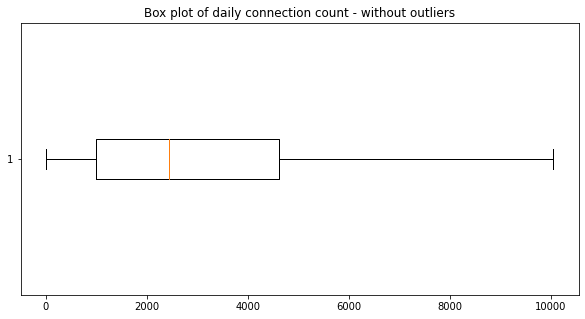

In [141]:
#Visualisation - data dispersion without outliers
plt.figure(figsize=(10,5))
plt.boxplot(user_id_df['count'],vert=False,showfliers=False)
plt.title('Box plot of daily connection count - without outliers')
plt.show()

Box plot of right skewed indicating daily connection count by user form long tail at higher values

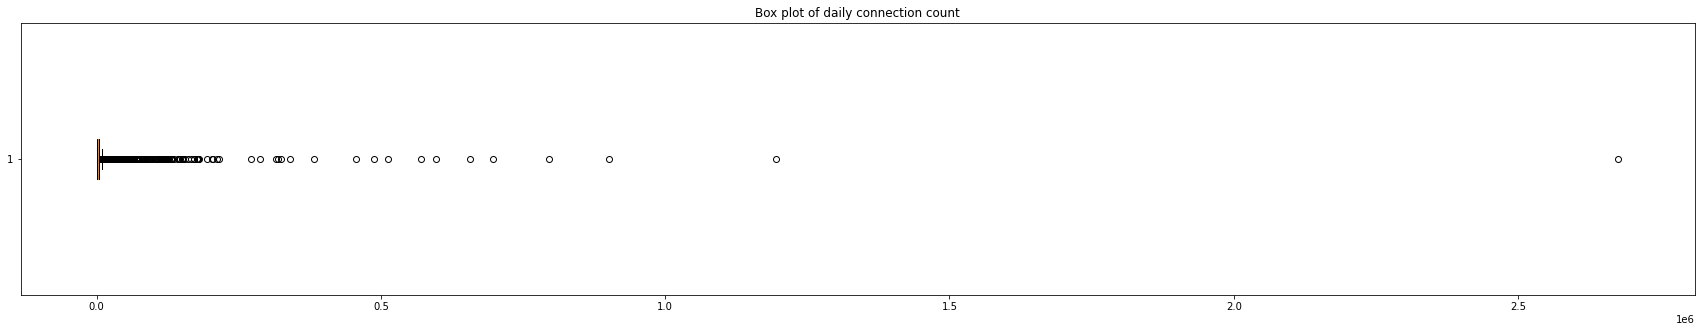

In [138]:
#Visualisation - data dispersion with outliers
plt.figure(figsize=(30,5))
plt.boxplot(user_id_df['count'],vert=False)
plt.title('Box plot of daily connection count - with outlier')
plt.show()

There are quite a few outlier daily connection count beyond Q3+IQR*1.5 range

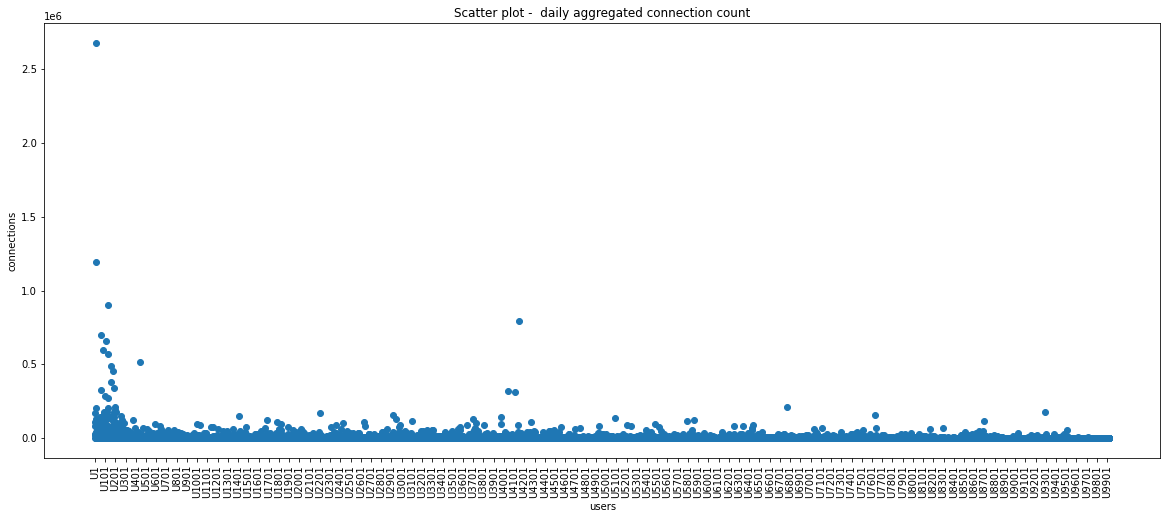

In [39]:
#Data dispersion visualisation using scatter plot
plt.figure(figsize=(20,8))
plt.scatter(user_id_df['user_id'],user_id_df['count'])
plt.title('Scatter plot -  daily aggregated connection count')
plt.xticks(user_id_df['user_id'][::100], rotation='vertical')
plt.xlabel('users')
plt.ylabel('connections')
plt.show()

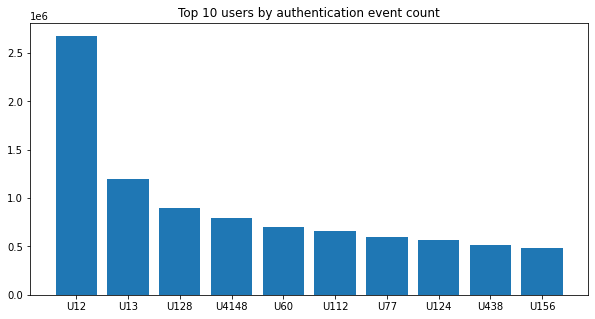

In [40]:
# Bar chart of users with top authentication events  
top_users_df = user_id_df.sort_values(by = 'count', ascending=False)[:10].reset_index(drop=True)
fig = plt.figure(figsize=(10,5))
subplot = fig.add_subplot()
subplot.bar(top_users_df['user_id'],top_users_df['count'],width = 0.8)
plt.title('Top 10 users by authentication event count')
fig.show()

In [41]:
# Event pattern of top users over period of time
# Hourly aggegating authentication events of top users 
timestamp_hour_boundary = 60*60
hours = df['timestamp'].max()/timestamp_hour_boundary
hourly_conn = []
df_hourly_user = pd.DataFrame(data = np.zeros((int(hours),top_users_df.shape[0])),columns = top_users_df['user_id'])
for i in range(int(hours)):
 df_hourly = df[(df['timestamp'] > i*timestamp_hour_boundary) & (df['timestamp'] < (i+1)*timestamp_hour_boundary)]
 for j in range(top_users_df.shape[0]):
    df_temp = df_hourly[df_hourly['user_id'] ==  top_users_df.at[j,'user_id']].groupby('user_id')['user_id'].agg(count='count').reset_index()
    if(not df_temp.empty):
      df_hourly_user.at[i,df_temp['user_id']] = df_temp['count'][0]

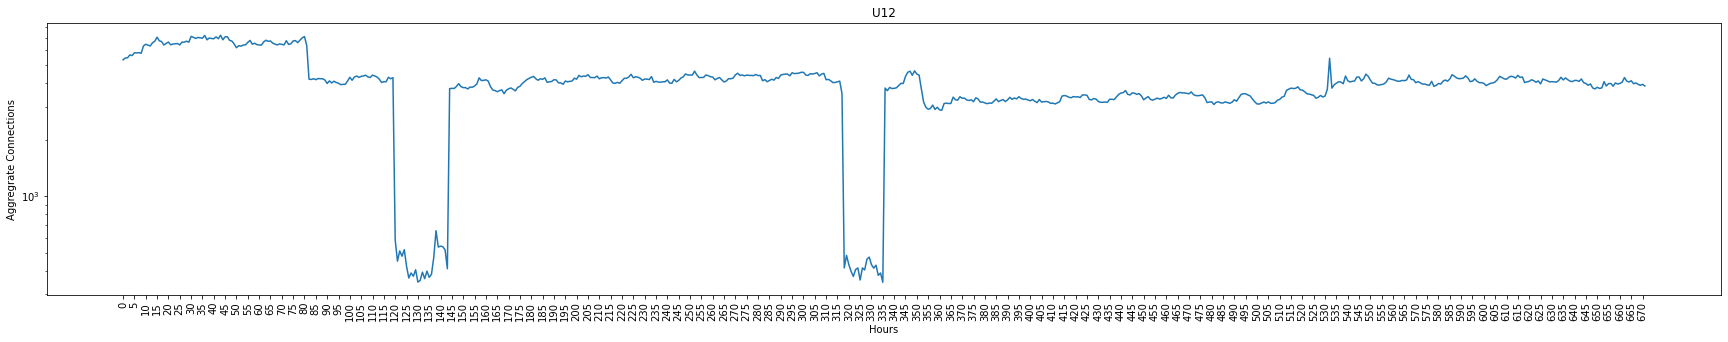

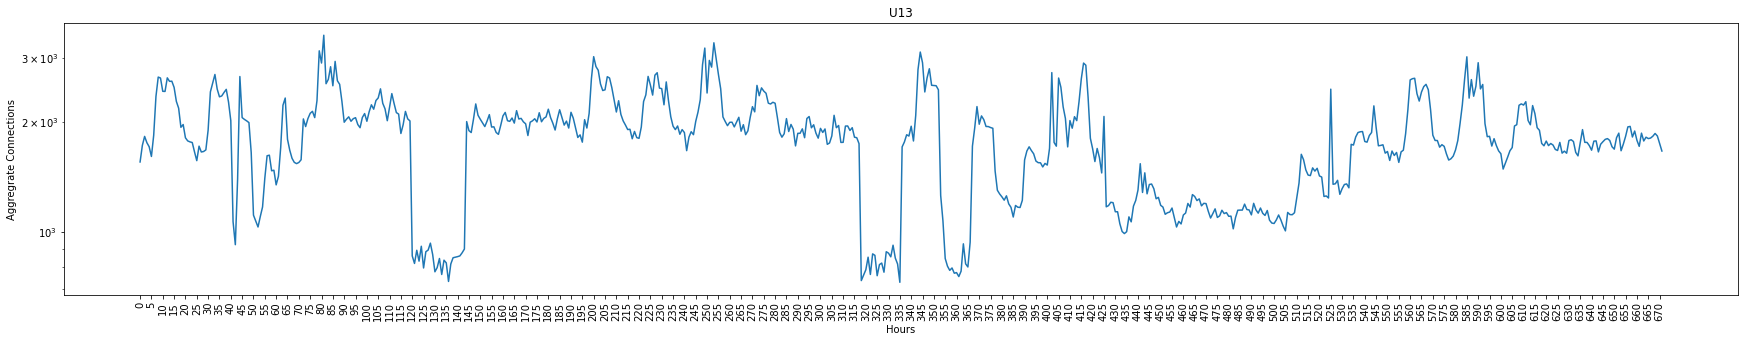

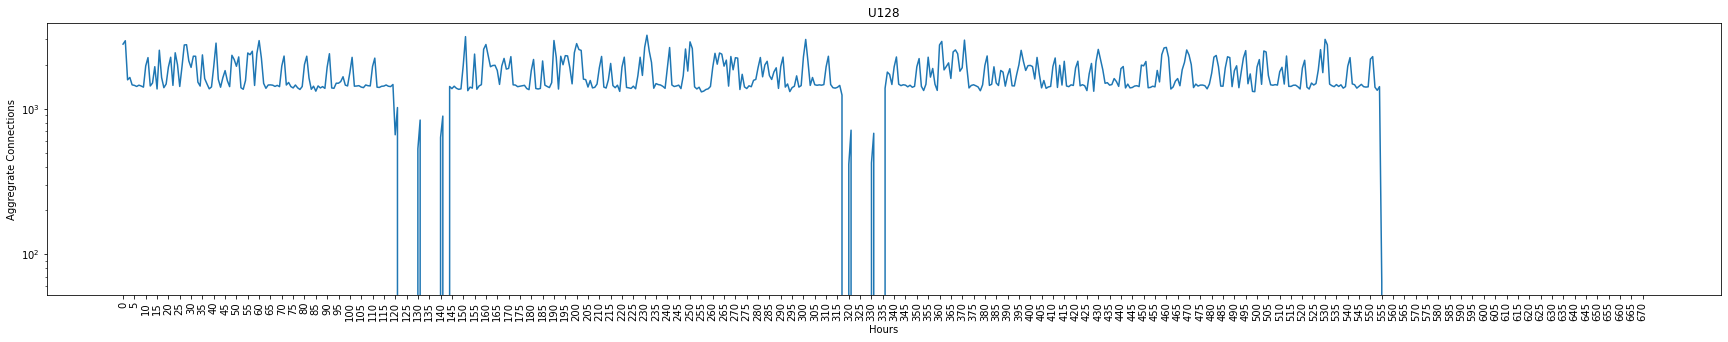

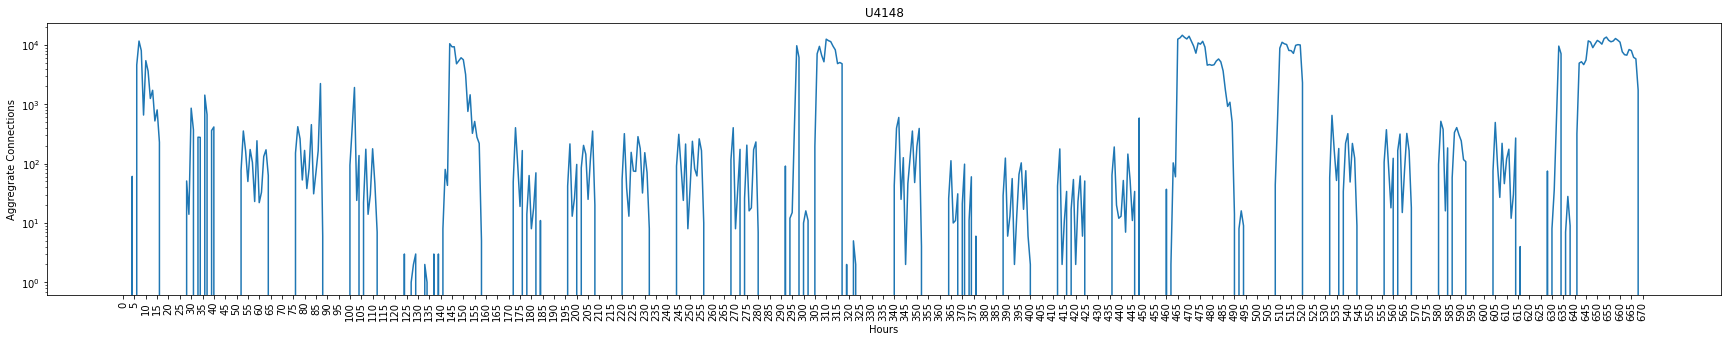

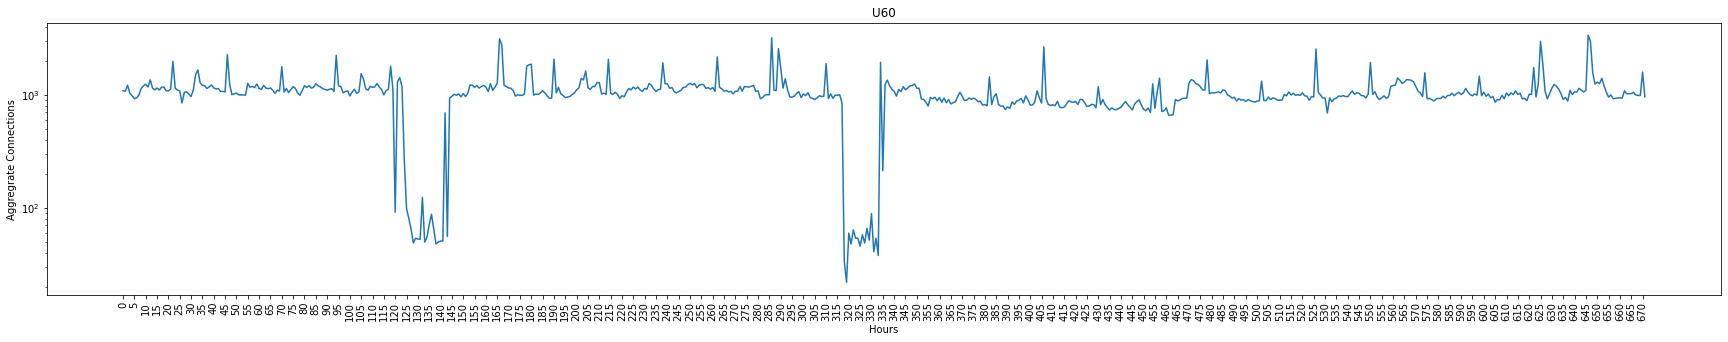

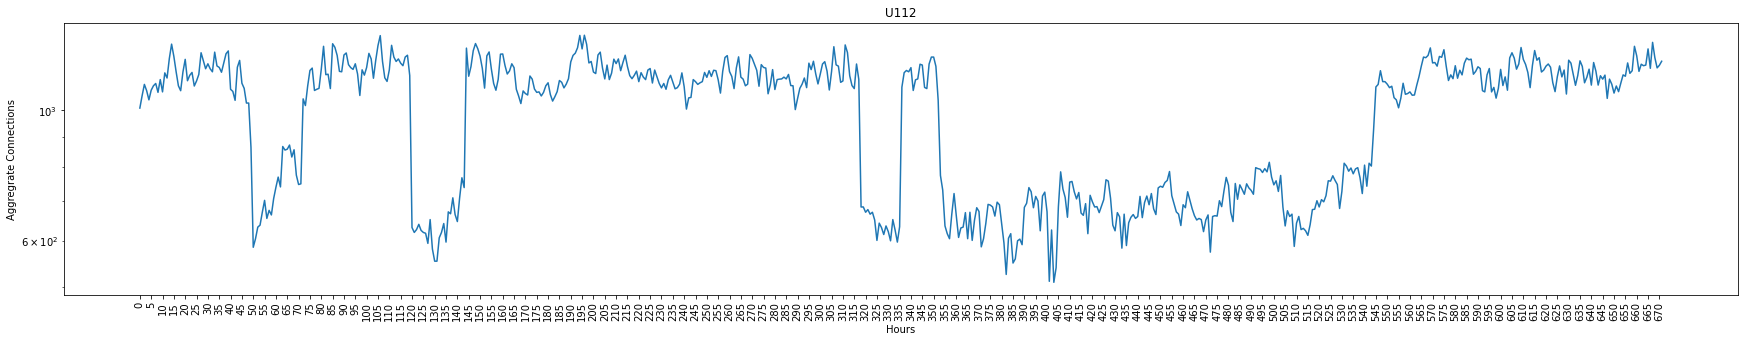

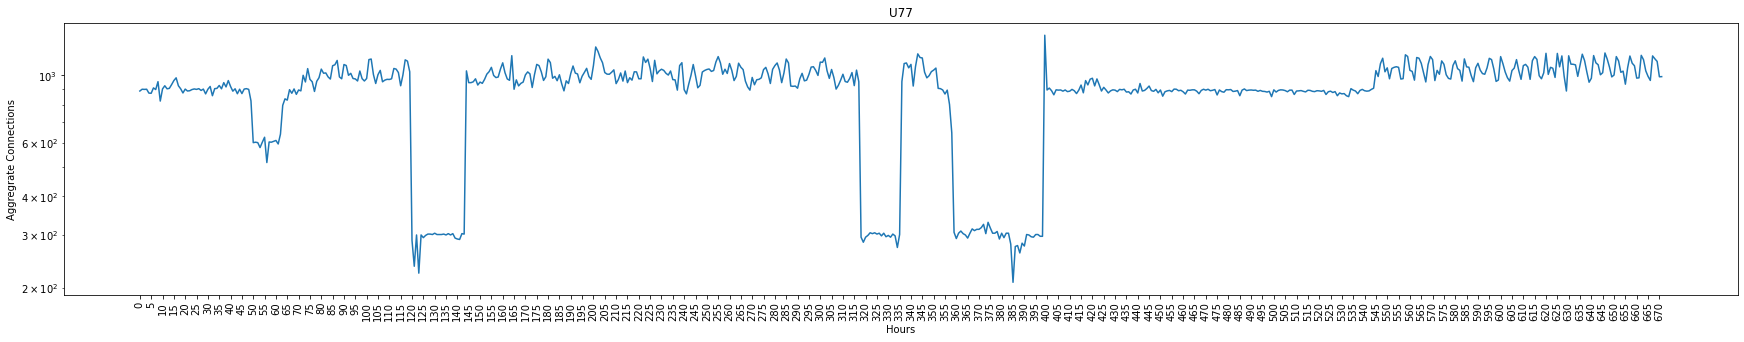

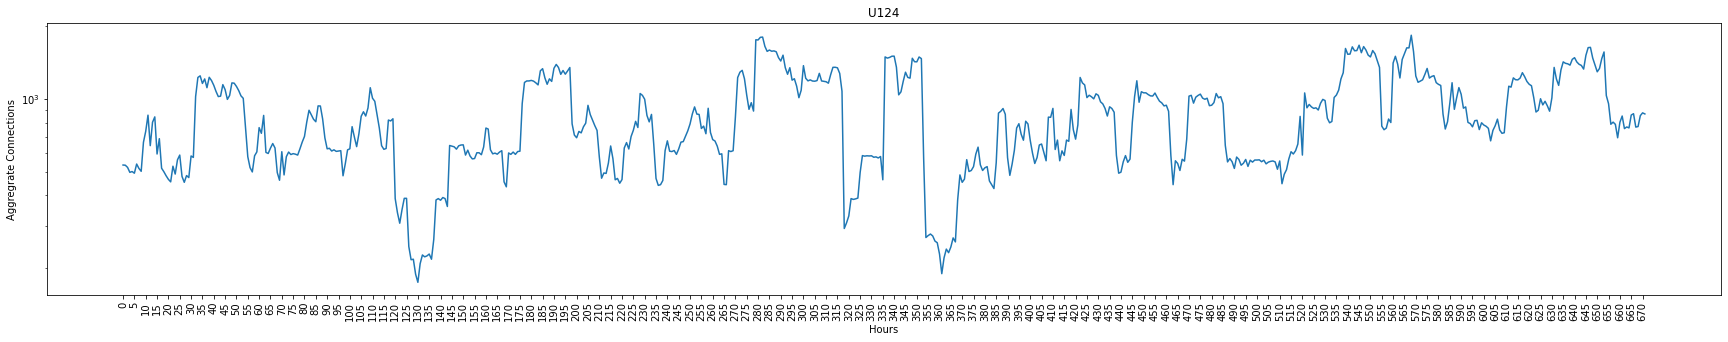

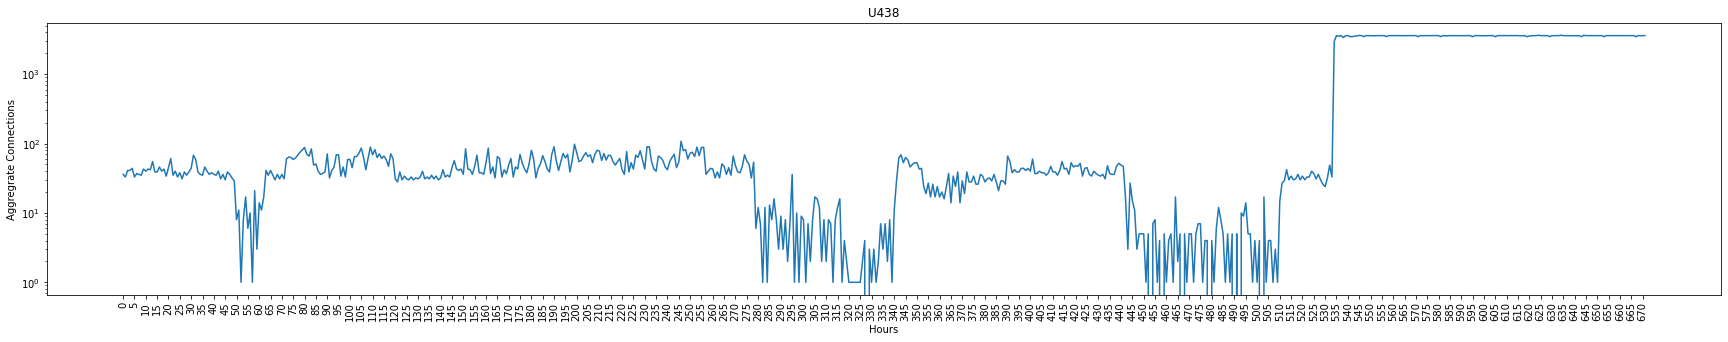

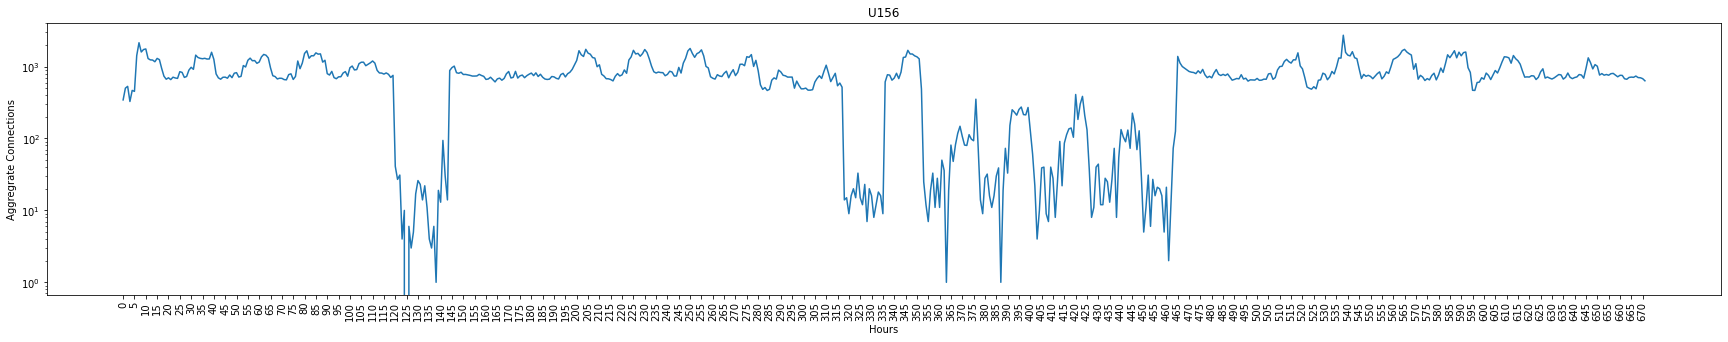

In [42]:
# Visualization - Hourly aggegating authentication events of users computers 
for i in range(df_hourly_user.shape[1]):
    plt.figure(figsize=(30,5))
    plt.yscale('log')
    plt.xlabel('Hours')
    plt.ylabel('Aggregrate Connections')
    plt.title(top_users_df.iloc[i,0])
    plt.xticks(np.arange(0,df_hourly_user.shape[0])[::5], rotation='vertical')
    plt.plot(df_hourly_user.iloc[:,[i]])

Each user has different patterns of authentication request with some preodicity

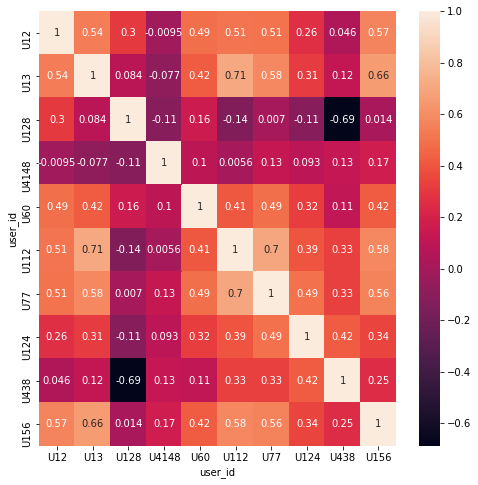

In [43]:
corrMatrix = df_hourly_user.corr()
plt.figure(figsize = (8,8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

There is a correlation between top user except U4148 and U128

#### Network Computers connection analysis
In this section we will explorer pattern of authentication request received by computers

In [44]:
# Aggregate authentication events generated for a computer
comp_id_series = df['comp_id'].value_counts()
comp_id_df = pd.DataFrame({'comp_id':comp_id_series.index,'count':comp_id_series.values})

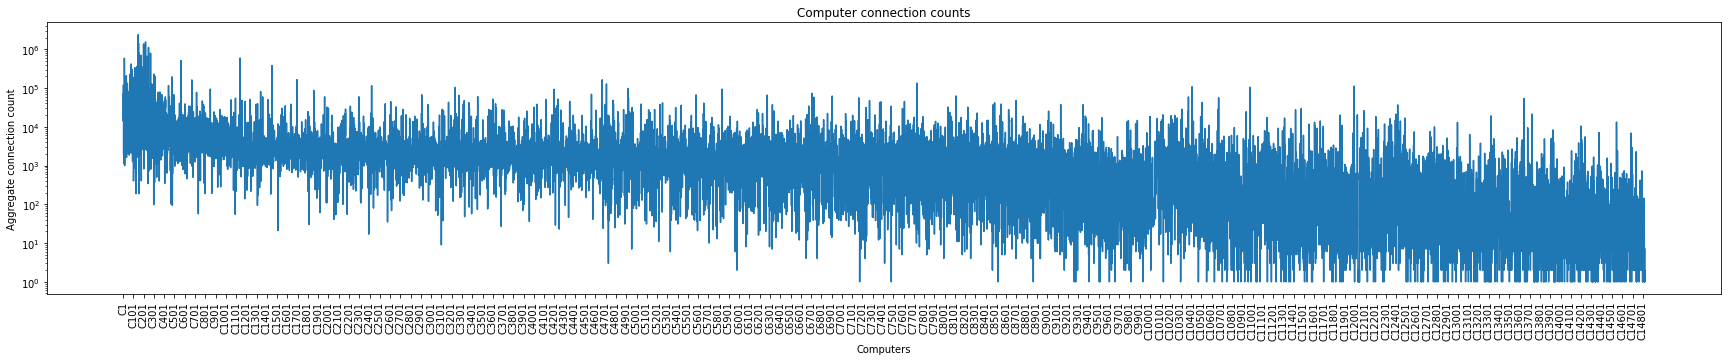

In [45]:
#Visualise - aggregate authentication events generated for a computer
comp_id_df['comp_id_temp'] = comp_id_df['comp_id'].str.split('C',expand = True)[1].astype('int32')
comp_id_df = comp_id_df.sort_values('comp_id_temp', ascending=True).drop(['comp_id_temp'], axis = 1).reset_index(drop=True)

plt.figure(figsize=(30,5))
plt.yscale('log')
plt.plot(comp_id_df['comp_id'],comp_id_df['count'])
plt.title('Computer connection counts')
plt.xlabel('Computers')
plt.ylabel('Aggregate connection count')
plt.xticks(comp_id_df['comp_id'][::100],  rotation='vertical')
plt.show()

Authentication events for computers at the beginning of series is higher than computers at the tail end of the series. This pattern is similar to aggregate events for user at the beginning of series and tail end of series

In [46]:
#Data dispersion analysis
print('Maximum aggregate authentication events for a computer {:d} '.format(comp_id_df['count'].max()))
print('Minimum aggregate authentication events for a computer {:d} '.format(comp_id_df['count'].min()))
print('Median aggregate authentication events for a computer {:.2f} '.format(comp_id_df['count'].median()))
print('Standard deviation of aggregate authentication events for a computer {:.2f}'.format(np.std(comp_id_df['count'])))

Maximum aggregate authentication events for a computer 2377727 
Minimum aggregate authentication events for a computer 1 
Median aggregate authentication events for a computer 1078.50 
Standard deviation of aggregate authentication events for a computer 37646.42


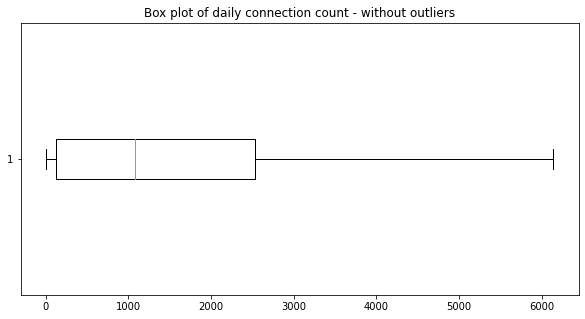

In [142]:
#Visualisation - data dispersion without outliers
plt.figure(figsize=(10,5))
plt.boxplot(comp_id_df['count'],vert=False,showfliers=False)
plt.title('Box plot of daily connection count - without outliers')
plt.show()

Box plot is right skewed indicating more variability in number of events for computers having higher daily connection count

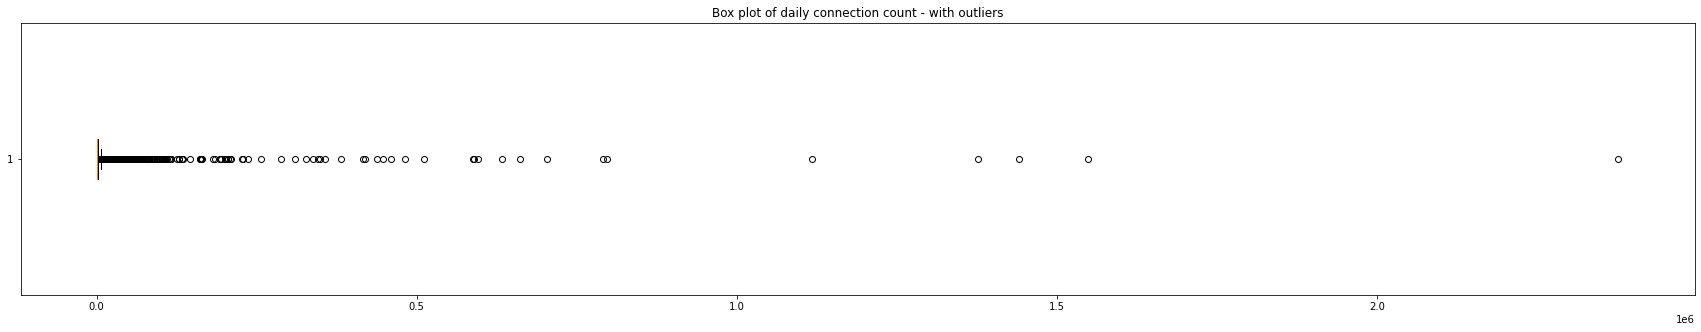

In [144]:
#Visualisation - data dispersion with outliers
plt.figure(figsize=(30,5))
plt.boxplot(comp_id_df['count'],vert=False)
plt.title('Box plot of daily connection count - with outliers')
plt.show()

Quite a few daily computer authentication events are marked as outlier 

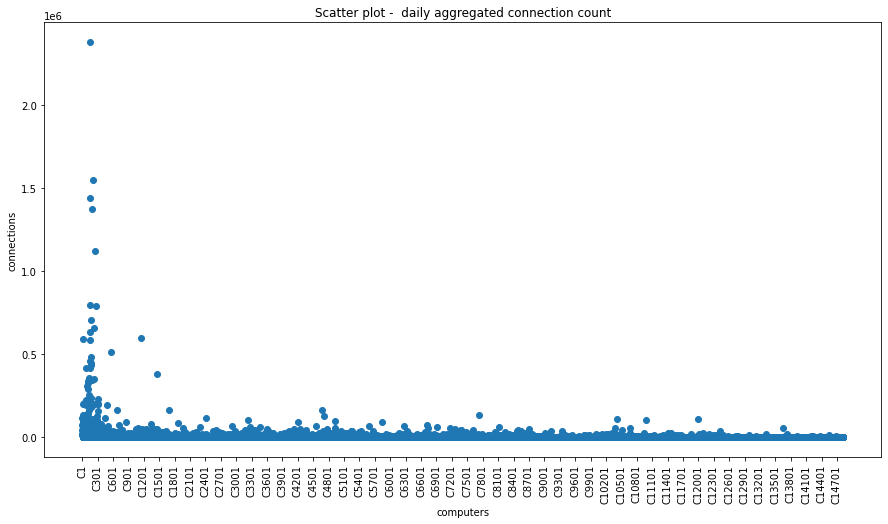

In [47]:
#Visualisation of data dispersion
plt.figure(figsize=(15,8))
plt.scatter(comp_id_df['comp_id'],comp_id_df['count'])
plt.title('Scatter plot -  daily aggregated connection count')
plt.xticks(comp_id_df['comp_id'][::300], rotation='vertical')
plt.xlabel('computers')
plt.ylabel('connections')
plt.show()

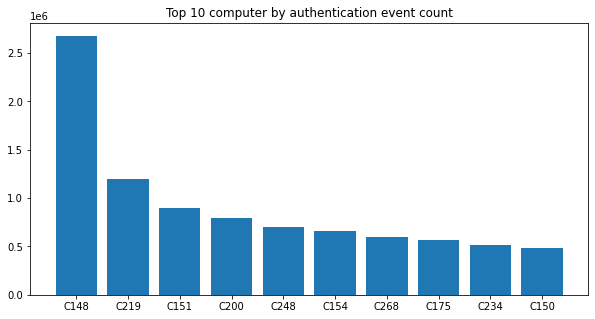

In [48]:
# Bar chart of computers with top authentication events 
top_comp_df = comp_id_df.sort_values(by = 'count', ascending=False)[:10].reset_index(drop = 'True')
fig = plt.figure(figsize=(10,5))
subplot = fig.add_subplot()
subplot.bar(top_comp_df['comp_id'],top_users_df['count'],width = 0.8)
plt.title('Top 10 computer by authentication event count')
fig.show()

In [49]:
# Event pattern of top computers over period of time
# Hourly aggegation authentication events of top computers 
timestamp_hour_boundary = 60*60
hours = df['timestamp'].max()/timestamp_hour_boundary
hourly_conn = []
df_hourly_comp = pd.DataFrame(data = np.zeros((int(hours),top_comp_df.shape[0])),columns = top_comp_df['comp_id'])
for i in range(int(hours)):
 df_hourly = df[(df['timestamp'] > i*timestamp_hour_boundary) & (df['timestamp'] < (i+1)*timestamp_hour_boundary)]
 for j in range(top_comp_df.shape[0]):
    df_temp = df_hourly[df_hourly['comp_id'] ==  top_comp_df.at[j,'comp_id']].groupby('comp_id')['comp_id'].agg(count='count').reset_index()
    if(not df_temp.empty):
      df_hourly_comp.at[i,df_temp['comp_id']] = df_temp['count'][0]

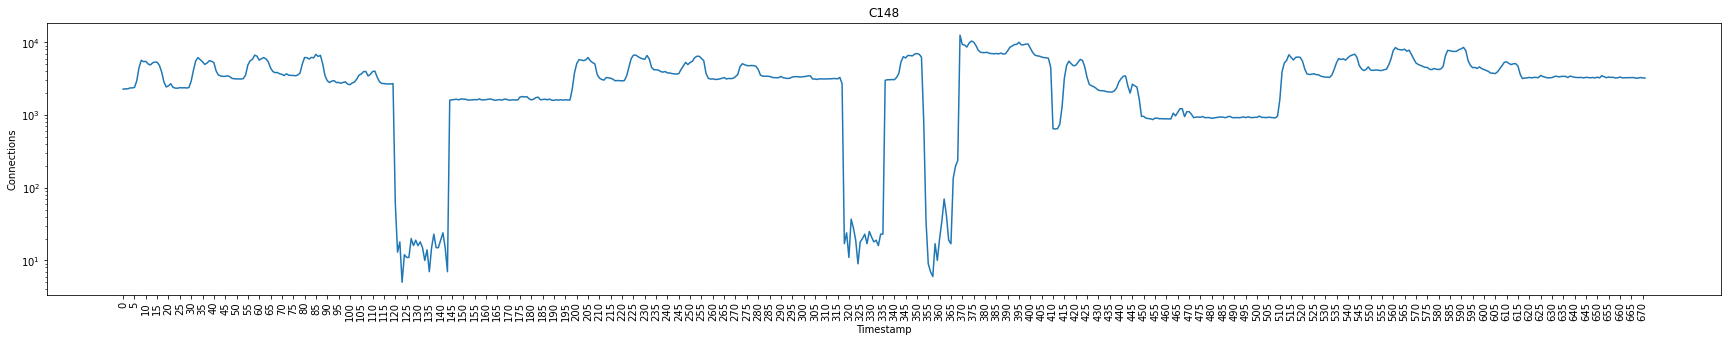

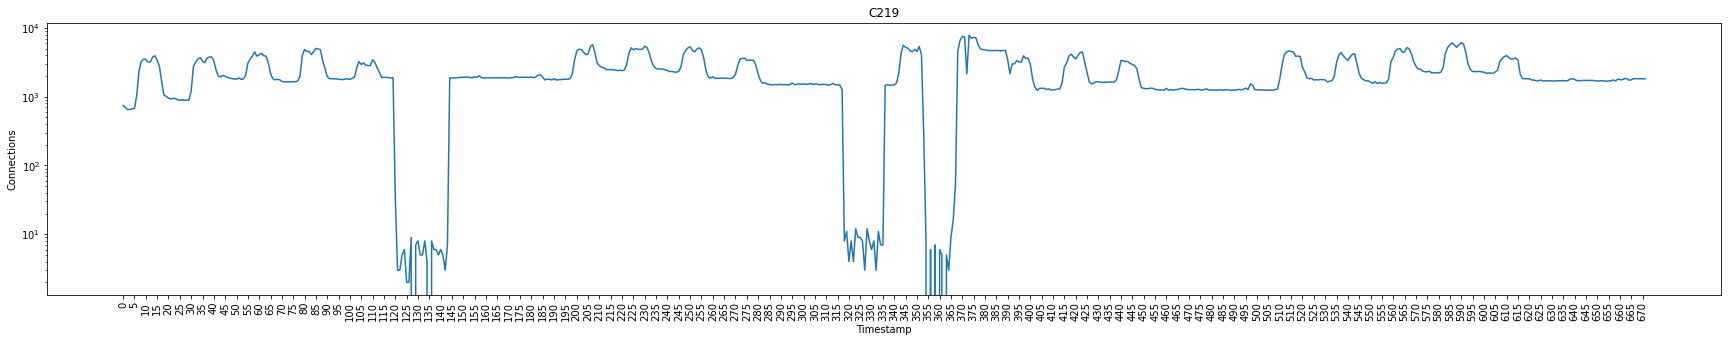

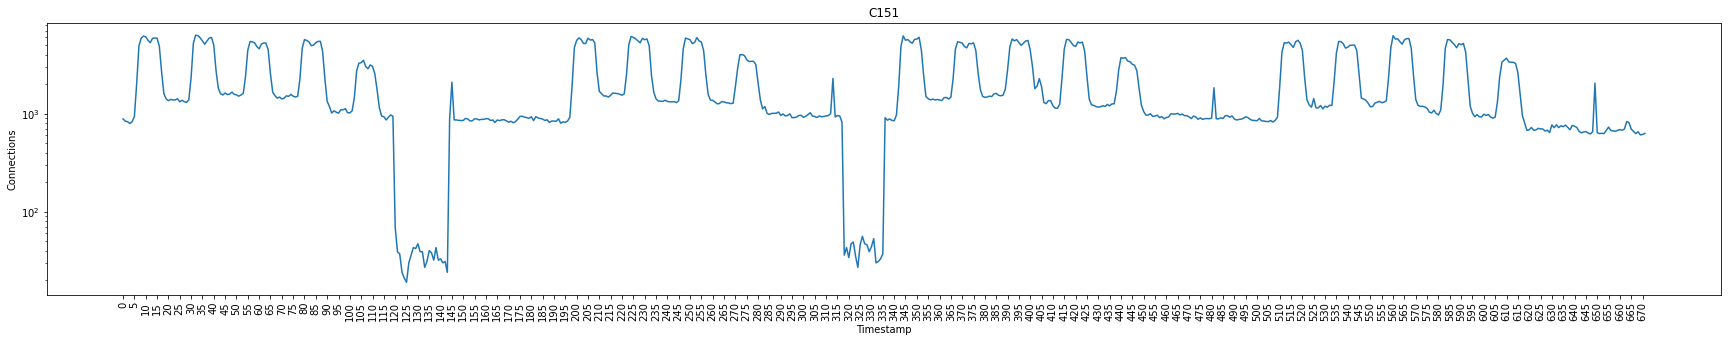

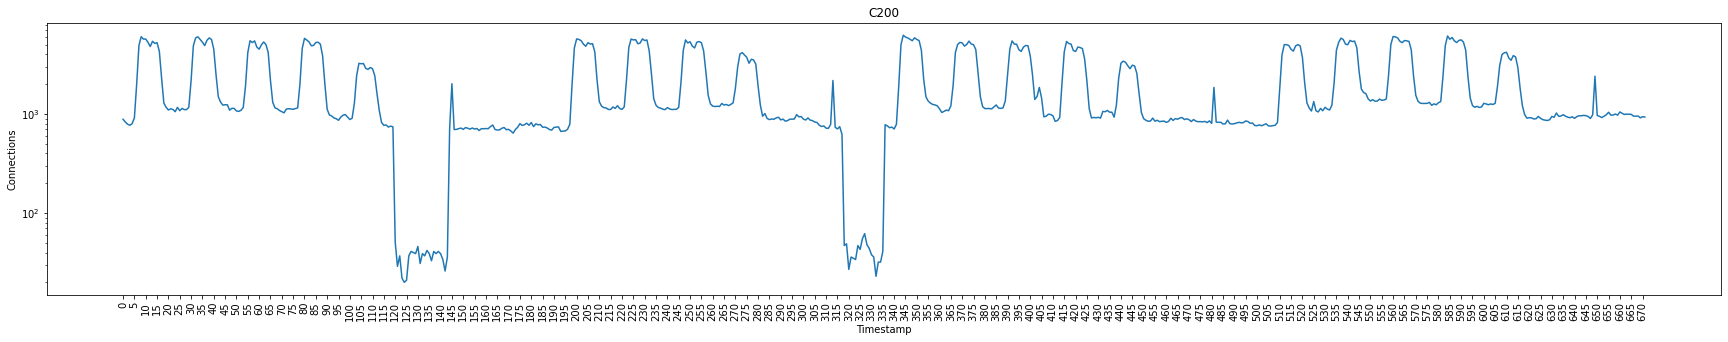

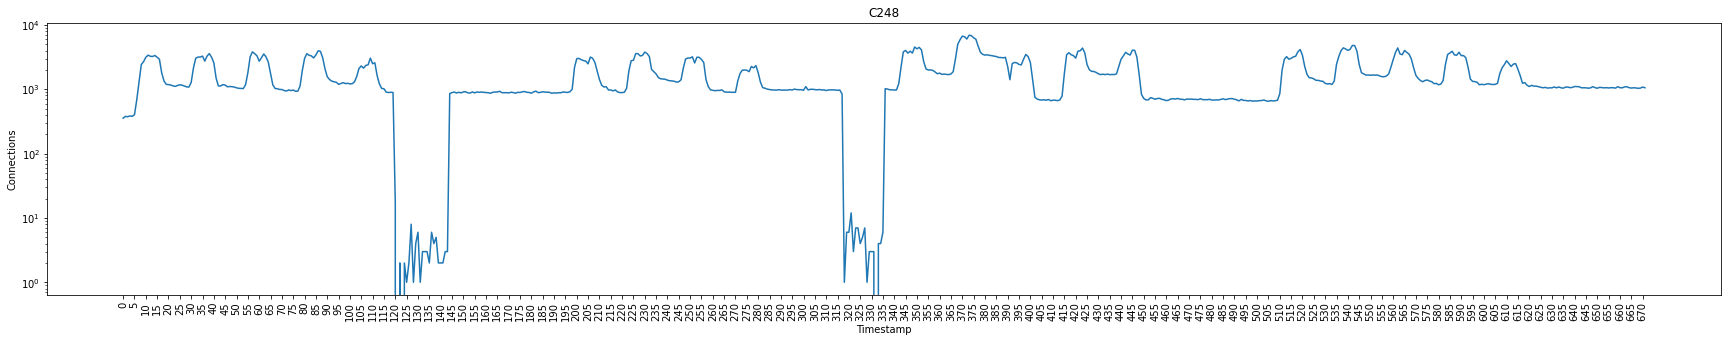

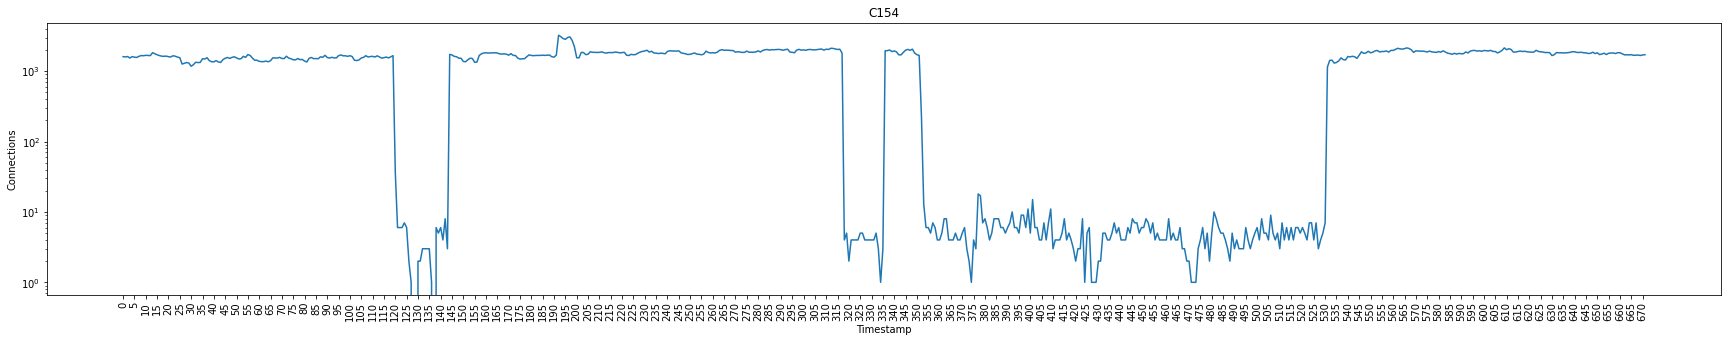

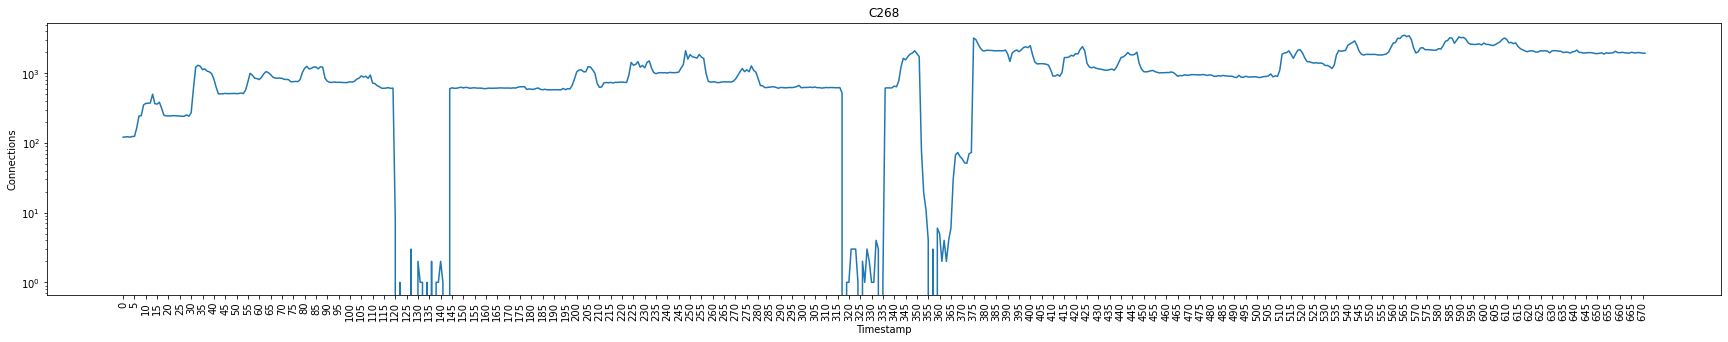

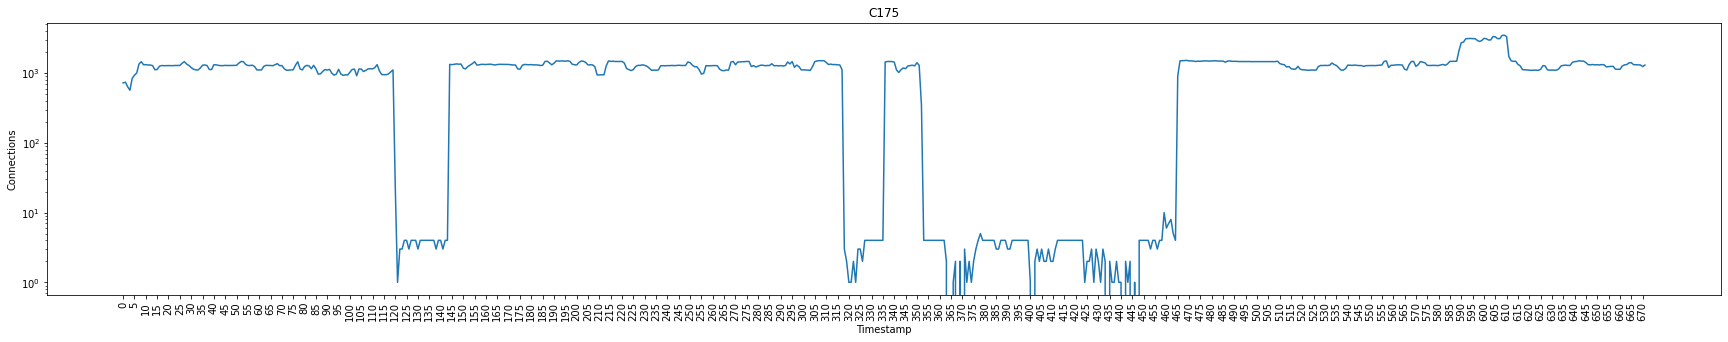

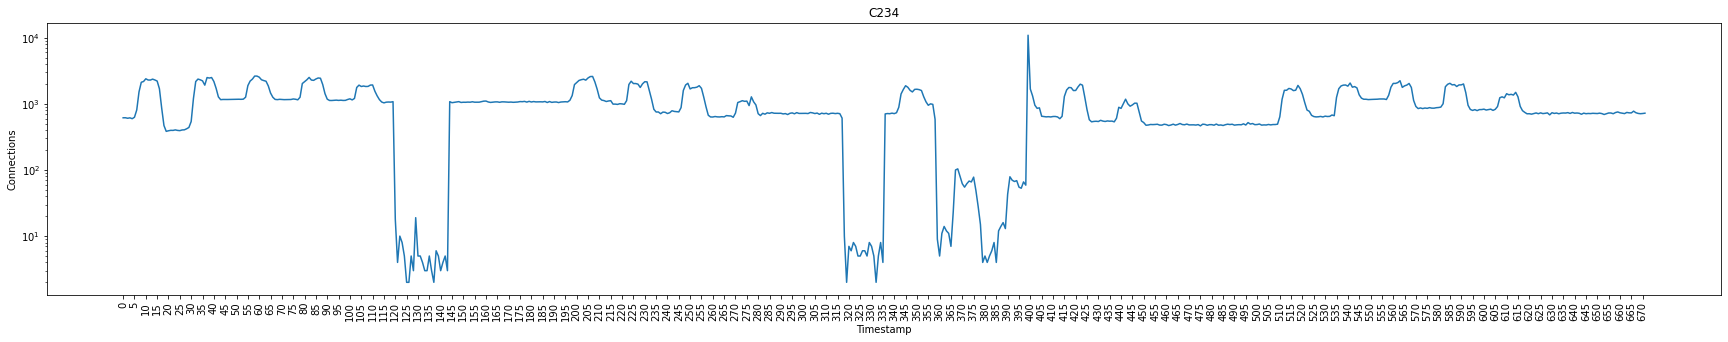

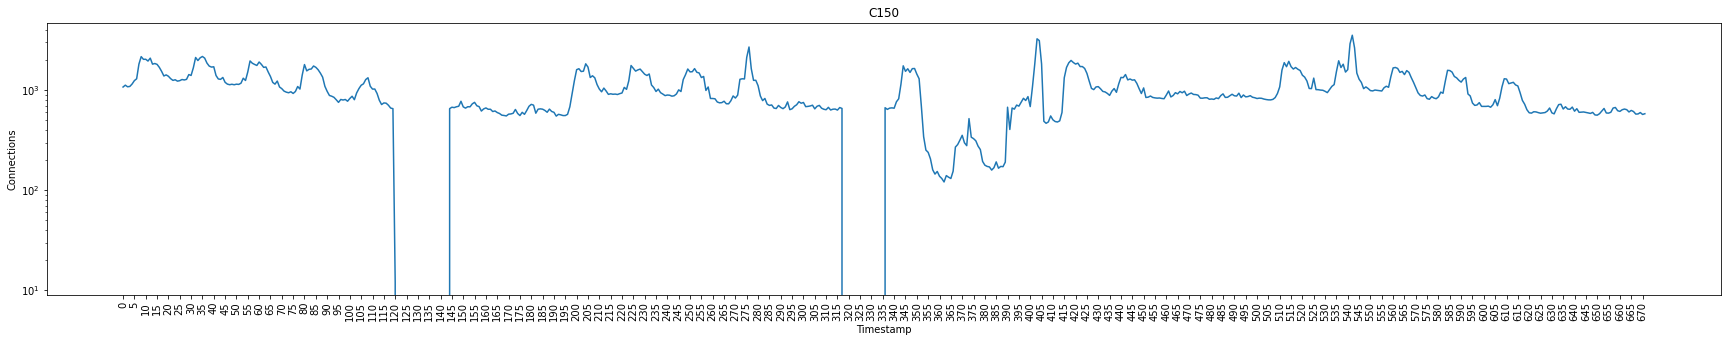

In [50]:
# Visualization - Hourly aggegating authentication events of top computers 
for i in range(df_hourly_comp.shape[1]):
    plt.figure(figsize=(30,5))
    plt.yscale('log')
    plt.xlabel('Timestamp')
    plt.ylabel('Connections')
    plt.title(top_comp_df.iloc[i,0])
    plt.xticks(np.arange(0,df_hourly_comp.shape[0])[::5], rotation='vertical')
    plt.plot(df_hourly_comp.iloc[:,[i]])

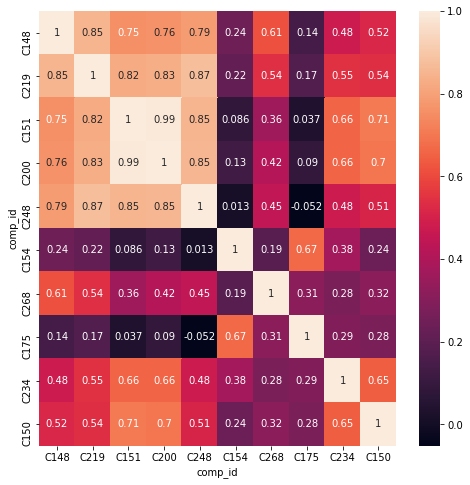

In [51]:
corrMatrix = df_hourly_comp.corr()
plt.figure(figsize = (8,8))
sn.heatmap(corrMatrix, annot=True)
plt.show()

There is a high level of correlation between top 5 computers C148,C129,C151,C200,C248. Also, there is correlation between other computers as well except C154 and C175

#### User Computer Interaction
This section explorer two dimmesional data interaction between users and computers

In [52]:
#Aggregating number of unique computer connection made by each user in network
user_g = df[['user_id','comp_id']].reset_index(drop = True).groupby('user_id')
user_comp_dic = {}
for u in df['user_id'].unique():
  user_comp_dic[u] = len(user_g.get_group(u)['comp_id'].unique())

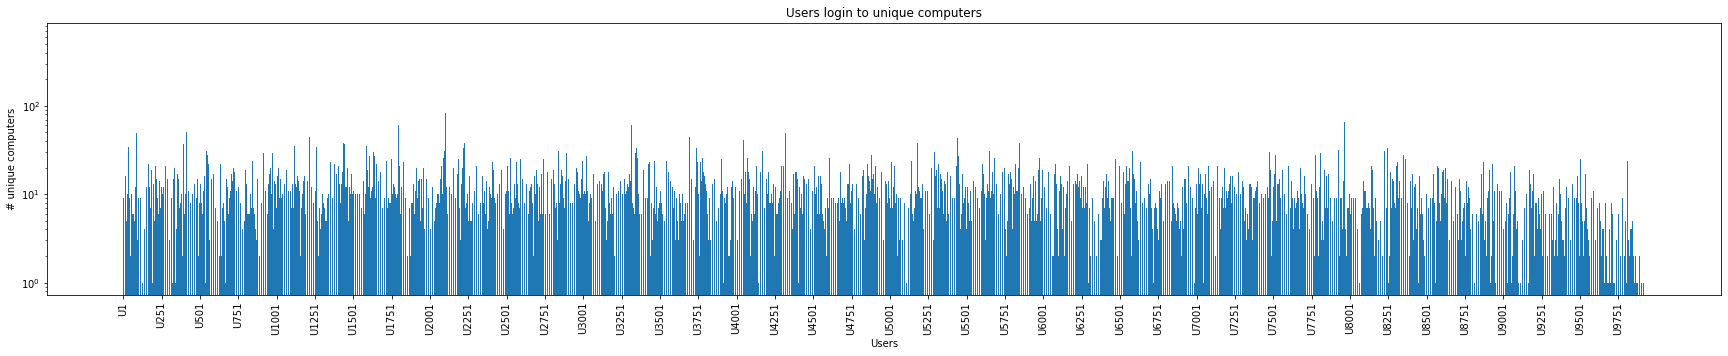

In [53]:
plt.figure(figsize=(30,5))
plt.bar(user_comp_dic.keys(),user_comp_dic.values())
plt.yscale('log')
plt.xticks(list(user_comp_dic.keys())[::250],  rotation='vertical')
plt.xlabel('Users')
plt.ylabel('# unique computers')
plt.title('Users login to unique computers')
plt.show()

In [54]:
print('Maximum unique computer by a user ' + str(max(user_comp_dic.values())))
print('Maximum unique computer by a user ' + str(min(user_comp_dic.values())))
print('Median unique computer by a user ' + str((statistics.median(user_comp_dic.values()))))

Maximum unique computer by a user 626
Maximum unique computer by a user 1
Median unique computer by a user 9.0


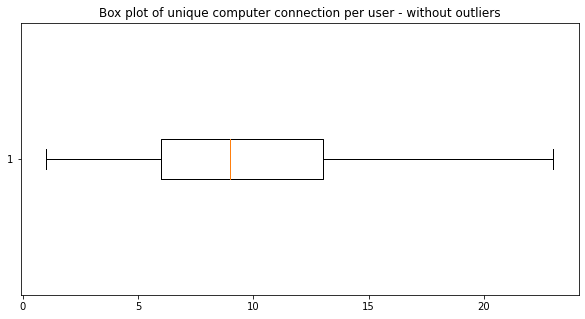

In [161]:
#Visualisation - data dispersion without outliers
plt.figure(figsize=(10,5))
plt.boxplot(user_comp_dic.values(),vert=False,showfliers=False)
plt.title('Box plot of unique computer connection per user - without outliers')
plt.show()

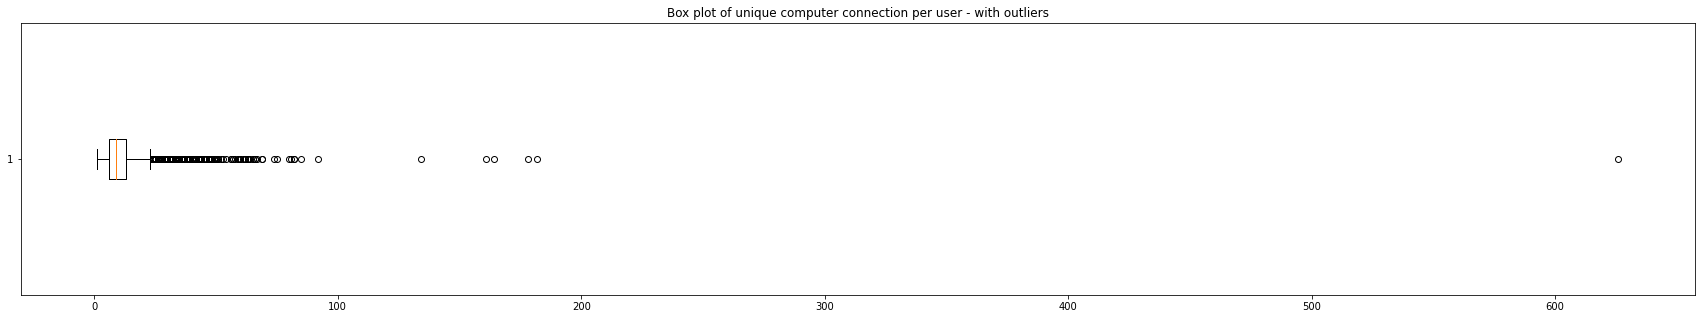

In [160]:
#Visualisation - data dispersion with outliers
plt.figure(figsize=(30,5))
plt.boxplot(user_comp_dic.values(),vert=False)
plt.title('Box plot of unique computer connection per user - with outliers')
plt.show()

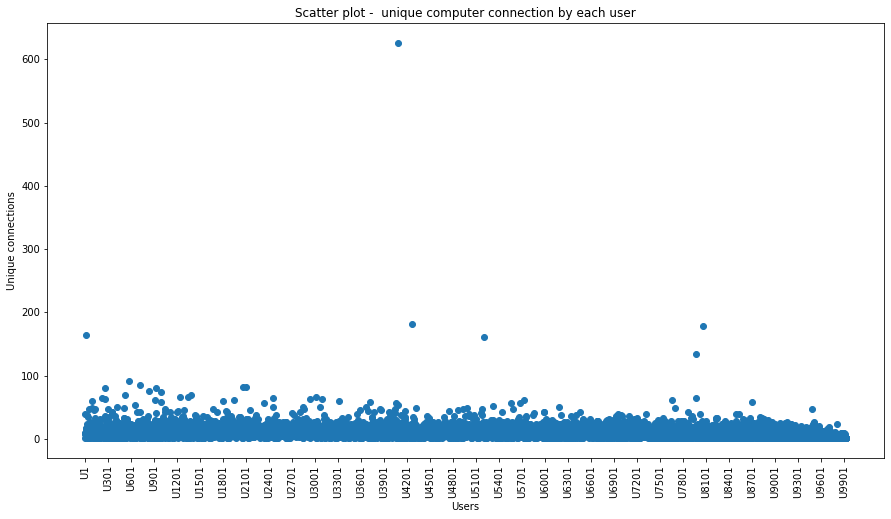

In [55]:
plt.figure(figsize=(15,8))
plt.scatter(user_comp_dic.keys(),user_comp_dic.values())
plt.title('Scatter plot -  unique computer connection by each user')
plt.xticks(list(user_comp_dic.keys())[::300], rotation='vertical')
plt.xlabel('Users')
plt.ylabel('Unique connections')
plt.show()

In [ ]:
# Matrix of computer id (columns) and user id (rows) capturing aggregate interaction between two over period of time
user_comp_df = pd.DataFrame(columns = df['comp_id'].unique())
for u in df['user_id'].unique():
  n = user_g.get_group(u)['comp_id'].unique()
  m = user_g.get_group(u).groupby('comp_id')
  r_dic = {}
  for k in range(len(n)): 
    r_dic[n[k]] = len(m.get_group(n[k]))
  user_comp_df = user_comp_df.append(r_dic, ignore_index=True)
user_comp_df = user_comp_df.fillna(0) 

In [ ]:
#user_comp_df.to_csv('/content/drive/My Drive/ML_Data/user_comp_df.csv')

In [56]:
user_comp_df = pd.read_csv('/content/drive/My Drive/ML_Data/user_comp_df.csv')

In [57]:
user_comp_df =user_comp_df.fillna(0)

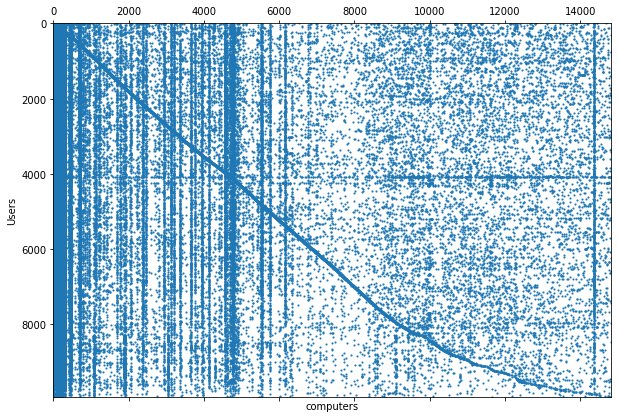

In [58]:
#Visualisation of user and computer interaction over period of time
plt.figure(figsize=(10,40))
plt.xlabel('computers')
plt.ylabel('Users')
plt.spy(user_comp_df,precision=1, markersize = 1, origin = 'lower')
plt.show()

Authentication events are dense between starting user id and computer ids. These events reduces are id's increases however there is a aberration in this pattern user id 4000 where this user is connecting many computers in network. Also computer around 14000 is being connected by all users in network. There is a thick diagonal line in graph indicating high number of events between user and computer on this line. 

#### Anomaly detection
Anomaly detection is of great interest in authentication event dataset to determine deviation from usual pattern to identify events that has to investigated by network administrator. 
As each user and computer forms different pattern of authentication connection over period of time, past connection patterns of user has to be analysed to form the opinion for future connection 

In [60]:
#Choosing two random users from top 10 users in authentication request
rand_users = top_users_df[['user_id']][:100].sample(2).to_numpy()
usr1 = str(rand_users[0][0])
usr2 = str(rand_users[1][0])

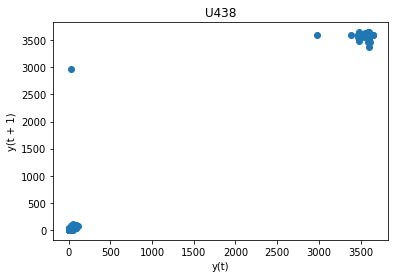

In [61]:
#Checking for self correlation for hourly data for each user
lag_plot(df_hourly_user[usr1],lag = 1)
plt.title(usr1)
plt.show()

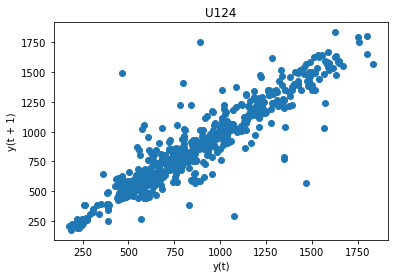

In [62]:
lag_plot(df_hourly_user[usr2],lag = 1)
plt.title(usr2)
plt.show()

In [63]:
#Defining neural network model
sequence_length = 100
model = Sequential()
model.add(LSTM(input_shape=(sequence_length-1,1),units = 32,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',optimizer='rmsprop')

In [64]:
#Creating neural network model for individual users

#Function takes user id and dataframe as input and return sequences and label for LSTM model
def get_data_seq_and_labels(in_user,in_dataframe,sequence_length):

  n_grams = []
  for ix in range(len(in_dataframe) - sequence_length):
    n_grams.append(in_dataframe[in_user][ix:ix+sequence_length])
  n_grams_arr = np.array(n_grams)

  #normalizing and shuffle the values
  n_grams_arr = n_grams_arr -  n_grams_arr.mean()
  n_grams_arr = n_grams_arr/n_grams_arr.std()
  np.random.shuffle(n_grams)

  #seperating each sample from its label
  x = n_grams_arr[:,:-1]
  labels = n_grams_arr[:,-1]
  x = np.reshape(x,(x.shape[0],x.shape[1],1))
  return x,labels

In [103]:
#Forecasting for usr1
x,labels = get_data_seq_and_labels(usr1,df_hourly_user,100)
model.fit(x,labels,batch_size=50,epochs=3,validation_split=0.05)

Epoch 1/3
11/11 [==============================] - 3s 285ms/step - loss: 0.0330 - val_loss: 0.0030
Epoch 2/3
11/11 [==============================] - 3s 281ms/step - loss: 0.0304 - val_loss: 0.0025
Epoch 3/3
11/11 [==============================] - 3s 287ms/step - loss: 0.0298 - val_loss: 0.0020


In [66]:
#Loading test data from next month
df2 = pd.read_csv('lanl-auth-dataset-1-01',names = ['timestamp','user_id','comp_id'])

In [67]:
#Aggerating data at hourly level for testing model
timestamp_hour_boundary = 60*60
hours = df2['timestamp'].max()/timestamp_hour_boundary
hourly_conn = []
df_hourly_user_test = pd.DataFrame(data = np.zeros((int(hours),top_users_df.shape[0])),columns = top_users_df['user_id'])
for i in range(int(hours)):
 df_hourly = df2[(df2['timestamp'] > i*timestamp_hour_boundary) & (df2['timestamp'] < (i+1)*timestamp_hour_boundary)]
 for j in range(top_users_df.shape[0]):
    df_temp = df_hourly[df_hourly['user_id'] ==  top_users_df.at[j,'user_id']].groupby('user_id')['user_id'].agg(count='count').reset_index()
    if(not df_temp.empty):
      df_hourly_user_test.at[i,df_temp['user_id']] = df_temp['count'][0]

In [119]:
x_test,y_test = get_data_seq_and_labels(usr1,df_hourly_user_test,100)

In [120]:
predicted = model.predict(x_test)

In [121]:
predicted = np.reshape(predicted, (predicted.size,))

In [122]:
square_deviation = ((predicted - y_test) **2)

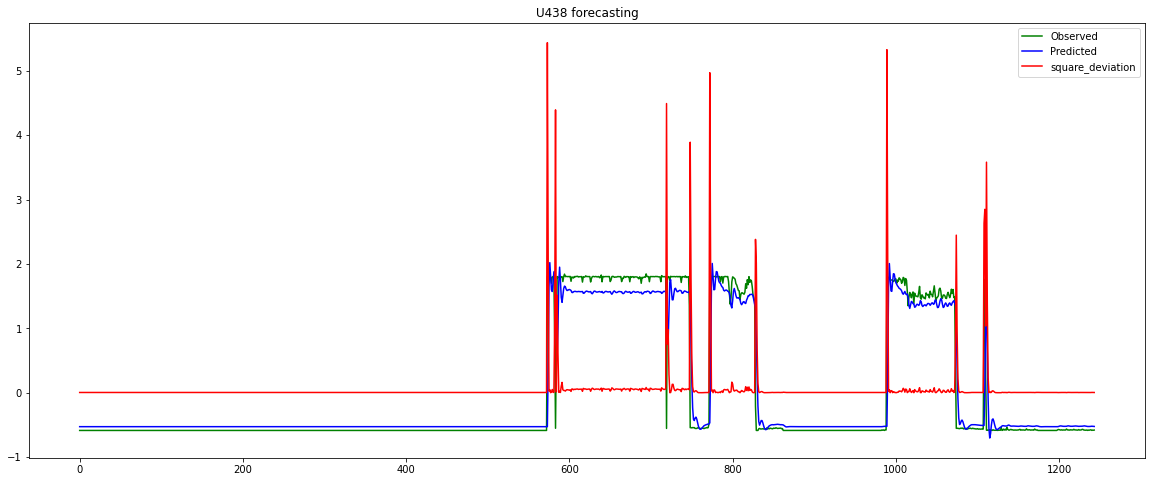

In [123]:
plt.figure(figsize=(20,8))
plt.plot(y_test[:len(y_test)], 'g', label='Observed')
plt.plot(predicted[:len(y_test)], 'b', label='Predicted')
plt.plot(square_deviation, 'r', label='square_deviation')
plt.title(usr1 + ' forecasting' )
plt.legend()
plt.show()

In [124]:
#Forcasting model accurancy
rmse = sqrt(mean_squared_error(y_test, predicted))
print("Root mean square error {:.2f} ".format(rmse))

Root mean square error 0.25 


In [125]:
#Forecasting for usr2
x,labels = get_data_seq_and_labels(usr2,df_hourly_user,100)
model.fit(x,labels,batch_size=50,epochs=3,validation_split=0.05)

Epoch 1/3
11/11 [==============================] - 3s 285ms/step - loss: 0.2232 - val_loss: 0.1755
Epoch 2/3
11/11 [==============================] - 3s 282ms/step - loss: 0.2451 - val_loss: 0.1793
Epoch 3/3
11/11 [==============================] - 3s 283ms/step - loss: 0.2124 - val_loss: 0.1466


In [126]:
x_test,y_test = get_data_seq_and_labels(usr2,df_hourly_user_test,100)

In [127]:
predicted = model.predict(x_test)

In [128]:
predicted = np.reshape(predicted, (predicted.size,))

In [129]:
square_deviation = ((predicted - y_test) **2)

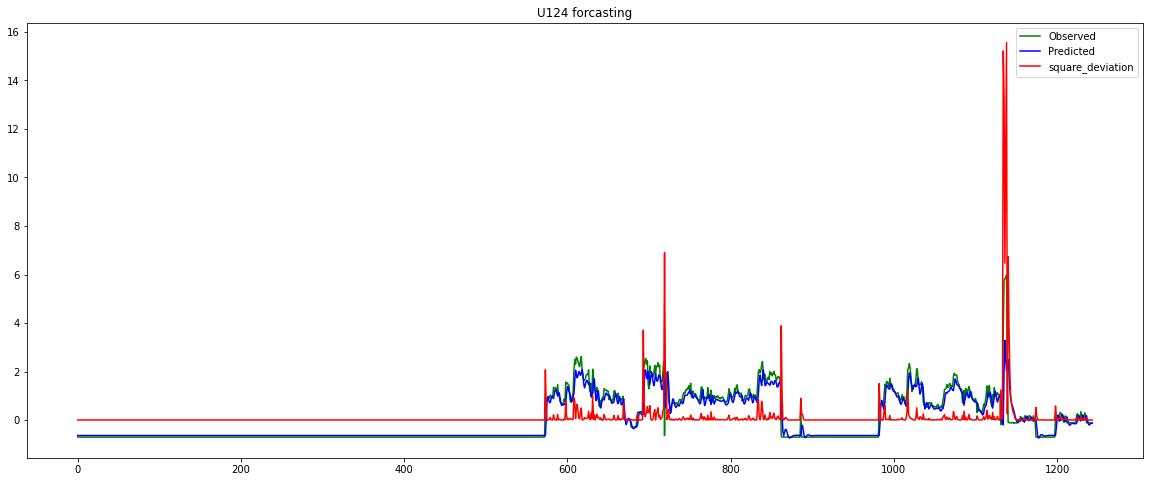

In [131]:
plt.figure(figsize=(20,8))
plt.plot(y_test[:len(y_test)], 'g', label='Observed')
plt.plot(predicted[:len(y_test)], 'b', label='Predicted')
plt.plot(square_deviation, 'r', label='square_deviation')
plt.title(usr2 + " forcasting")
plt.legend()
plt.show()

In [132]:
#Forcasting model accurancy
rmse = sqrt(mean_squared_error(y_test, predicted))
print("Root mean square error {:.2f} ".format(rmse))

Root mean square error 0.35 
